# Notebook demo de sesion de registro en campo



In [1]:
import sounddevice as sd       
from acousticfield.session import RecordingSession
from acousticfield.io import play, play_rec
from acousticfield.process import make_filterbank
from acousticfield.room import paracoustic
from acousticfield.display import *

# Ajuste de sounddevice
Elegir la interfaz de entrada salida si es necesario con sd.default_device[devicein,deviceout] usando los numeros que devuelve query_devices()

In [2]:
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 iShowU Audio Capture, Core Audio (2 in, 2 out)
  3 ZoomAudioDevice, Core Audio (2 in, 2 out)

In [3]:
#sd.default.device = [2,2]
fs = 48000

# Inicio de Sesion

Generacion de Metadata y nombres de archivo para los registros

In [4]:
parlantes = ["L","R","centro"]
mics = ["pub1","pub2"]
tipo = "Mono"
inchan = [0,1]
outchan = [0,1]
loopback = 1
s = RecordingSession("Session1",parlantes,mics,inchan=inchan,outchan=outchan,loopback=loopback,
                     rtype=tipo,sampling_rate=fs,sweepfile="sweep_x1_48k_10s_30_22k")

In [5]:
vars(s)

{'session_id': 'Session1',
 'speakers': ['L', 'R', 'centro'],
 'microphones': ['pub1', 'pub2'],
 'speaker_pos': [0, 0],
 'microphone_pos': [0, 0],
 'input_channels': [0, 1],
 'output_channels': [0, 1],
 'loopback': 1,
 'sampling_rate': 48000,
 'rtype': 'Mono',
 'date': '2023-05-20',
 'hour': '17:38:16',
 'comments': '',
 'sweepfile': 'sweep_x1_48k_10s_30_22k',
 'rpath': '',
 'recordings': []}

In [6]:
# s = RecordingSession.load_metadata("Sesion1")

# Grabacion de Respuesta Impulso

In [6]:
# los argumentos son: #parlante, #mic #dir #take #comentarios. 
parlante=1
mic=1
direction=1
take=1
comment = ""
ir1 = s.record_ir(parlante,mic,direction=direction,take=take,comment=comment)

Recording ... Session1_SL_Mpub1_D1_2ch_loop_Mono
finished
Maximum sample value = 1.660838007926941
Extracting ---> Session1_SL_Mpub1_D1_2ch_loop_Mono
IR shape = (284865, 1)
DONE


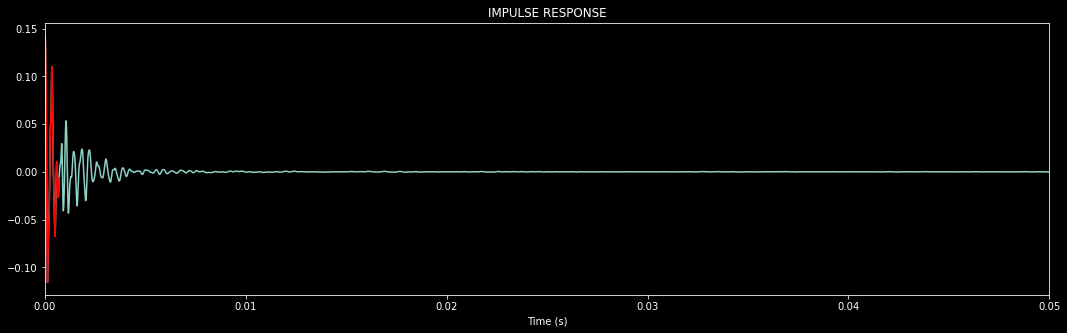

In [8]:
ir_plot(ir1,fs=fs,tmax=0.05)

## Acceder a registros previos

In [9]:
# lista de grabaciones (para agregar comentarios comments=True)
s.list_recordings(comments=True)

0:Session1_SL_Mpub1_D1_2ch_loop_Mono -- 


In [10]:
# carga una ir por numero de grabacion arrancando de 0
ir2 = s.load_ir(0)

In [11]:
# para reproducir normalizada
play(ir2,chanout=[0,1],normalized=True,fs=fs)

# Guardar y Cargar datos de sesion

In [ ]:
s.save_metadata("Session1")
# s = RecordingSession.load_metadata("Sesion1")

# Analisis de IR

Analisis en el dominio del tiempo

- Ecograma `echo_display` Tabla de ecos (primeras reflexioes)
- Estadistica `irstat_plot` Mixin time a partir de la kurtosis y el stdexcess, la linea vertical separa el directo del reverberante
- Autocorrelacion `acor_plot`

In [18]:
#echos = echo_display(ir1,0,fs=fs)

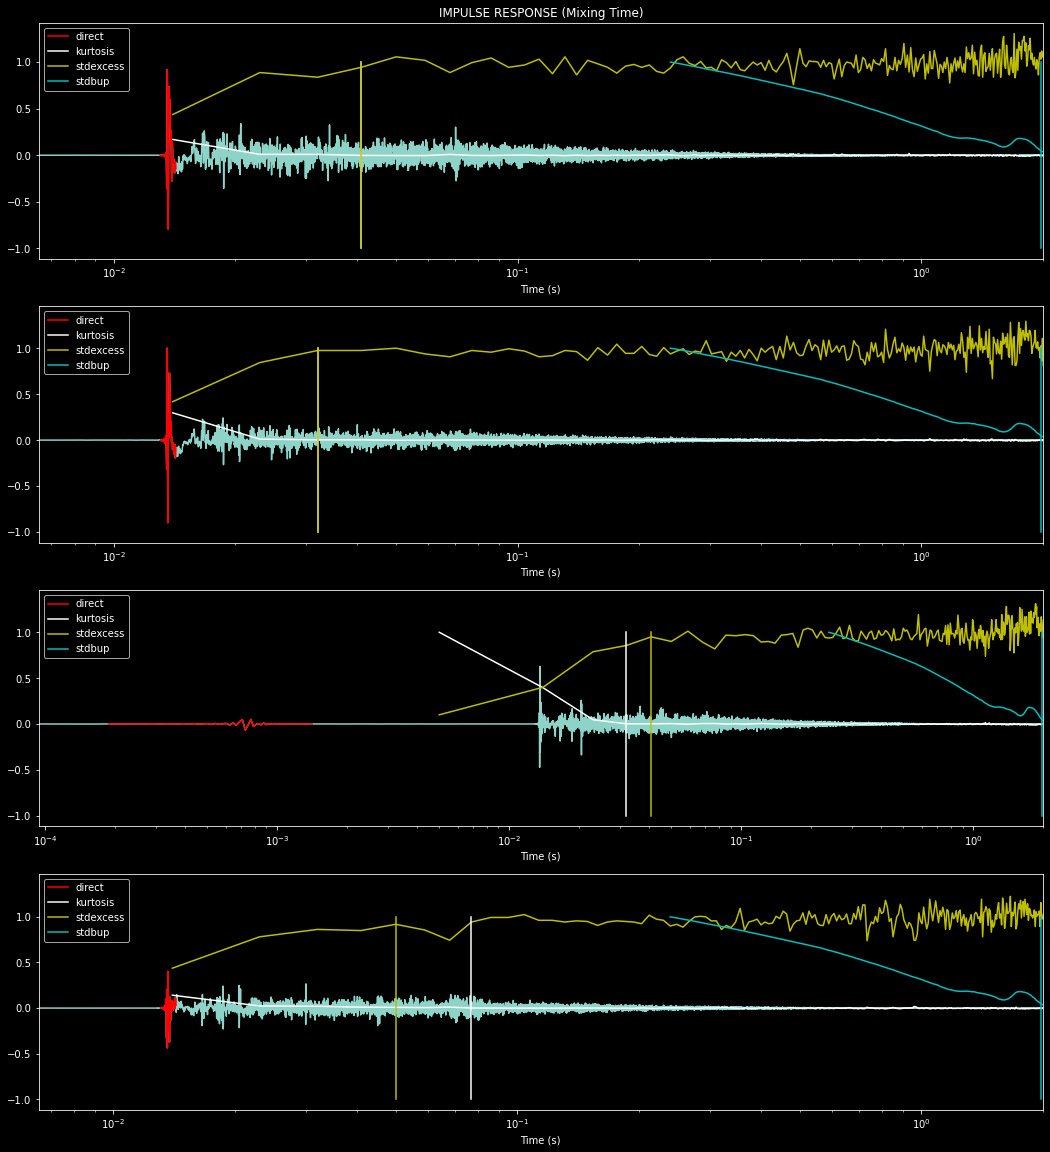

In [22]:
pstat = irstat_plot(ir1, window=0.01, overlap=0.001, logscale=True, fs=fs)

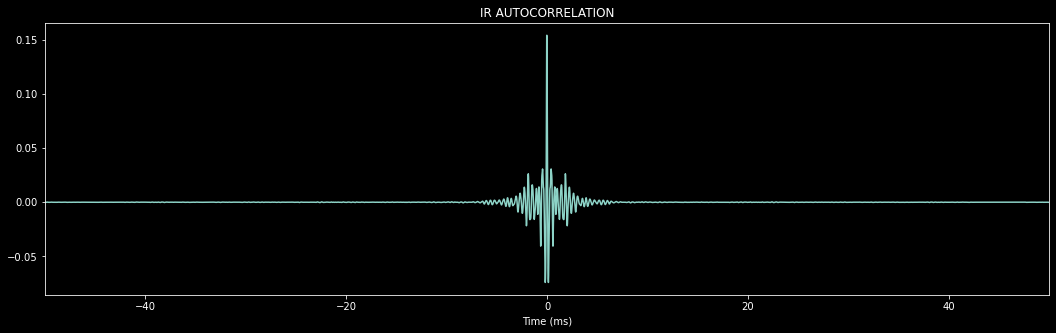

In [20]:
ac = acorr_plot(ir1,trange=0.05,fs=fs)

# Parametros acusticos

Calculo de los parametros acusticos usando paracoustic, el primer parametro es la RI (el array o el nombre de archivo), se puede especificarl el metodo para calcular el tiempo de reverberacion (rt30, rt20, rt15) y el banco de filtros a utilizar (el formato de nombre para el banco de filtros es fbank + frecuencia de sampleo + _ + numero de octavas + _ + numero de bandas por octavas. Por defecto el banco arranca en la octava de 62.5 para modificarlo se puede usar la funcion make_filterbank de process.

**paracoustic** devuelve un diccionario con todos los parametros por bandas, y dos columnas adicionales para ponderacion A y Flat. 

**pars_print** imprime todos los parametros (tambien se le puede pasar una lista de keys).

**pars_plot** hace graficos de los parametros que se le pasan como key.

Los parametros que se calculan son
- 'snr' relacion señal ruido en dB
- 'rt20' (o 'rt30' o 'rt15) tiempo de reverberacion en segundos
- 'edt' decaimiento temprano en segundos
- 'c50' y 'c80' claridad en dB con dos criterios
- 'ts' centro temporal en segundos
- 'dr' relacion directo reverberante en dB

Pero paracoustic tambien devuelve:
- 'rvalue' coeficiente de regresion del ajuste del decaimiento (puede incorporarse a parsprint)
- 'schr' integral de Schroeder para graficar el decaimiento
- 'lfit' 'tfit' intersecciones con tiempo y nivel donde realiza el ajuste de decaimiento

La funcion **parsdecay_plot** muestra los decaimientos por bandas en un multiplot.

En todos los casos muestra los datos de un solo canal (por defecto el canal 0 pero se puede especificar con el parametro chan)

In [18]:
#from acousticfield.process import make_filterbank
make_filterbank(fmin=62.5,noct=9,bwoct=1,fs=fs,bankname='fbank48k_9_1',show=True)

Banco de filtros generado: 9 octavas,1 bandas/octava,desde 62.5 Hz,Almacenada en archivo fbank48k_9_1


In [56]:
pars = paracoustic(ir1, method='rt20',bankname='fbank48k_9_1')

Using sample rate from filter bank:48000


In [57]:
pars_print(pars,chan=1)

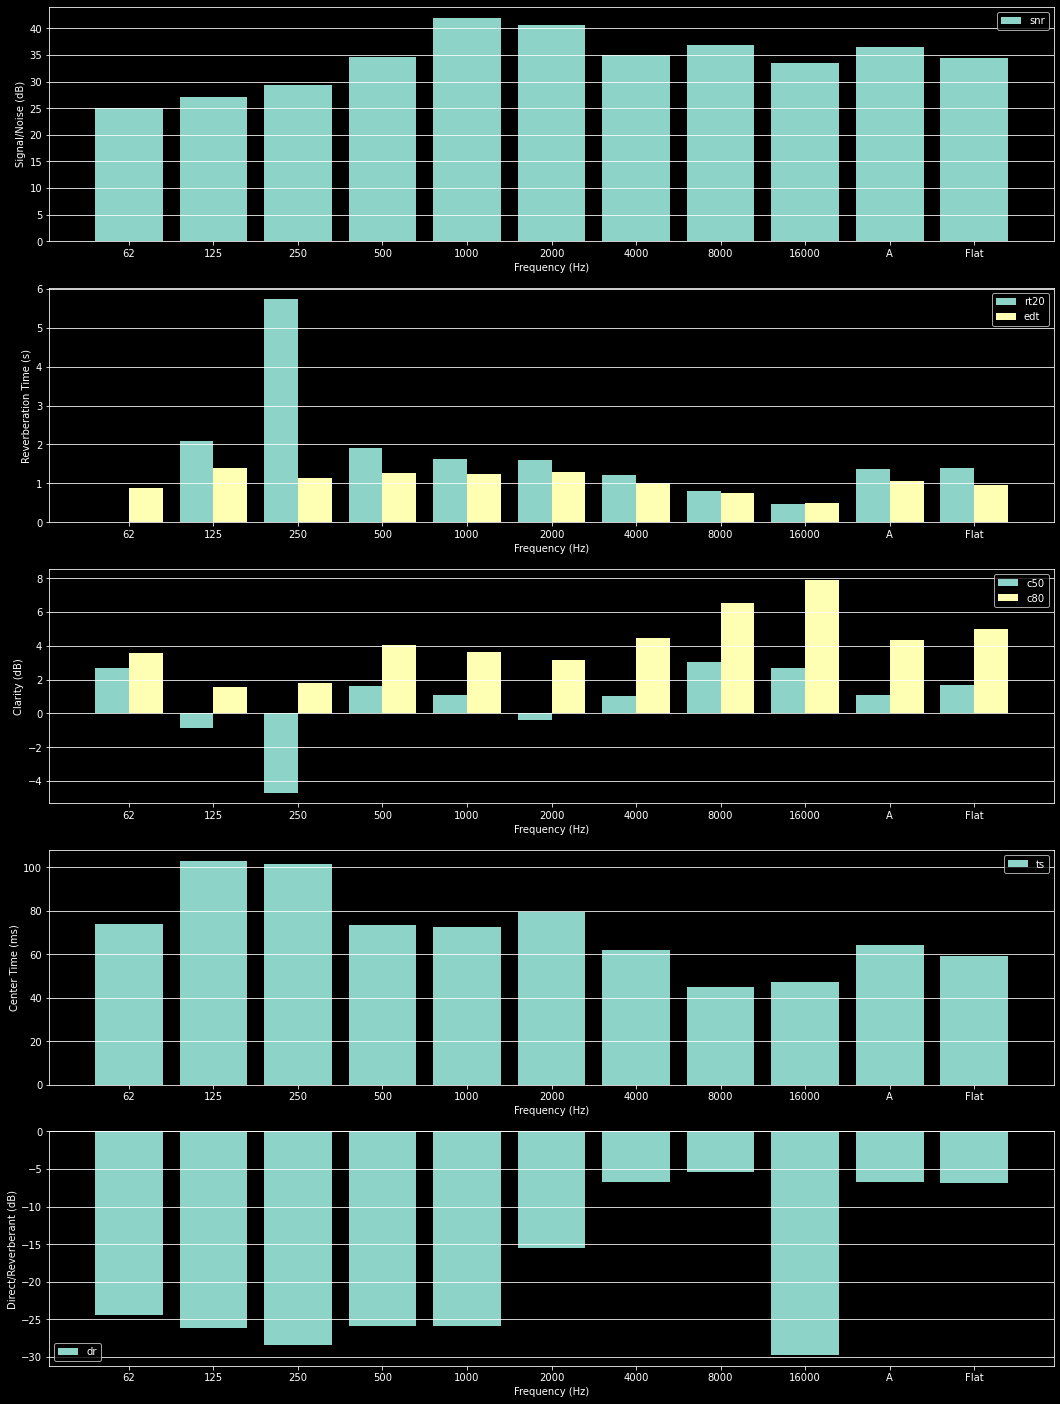

In [34]:
pars_plot(pars,['snr','rt20','c80','ts','dr'],chan=0)

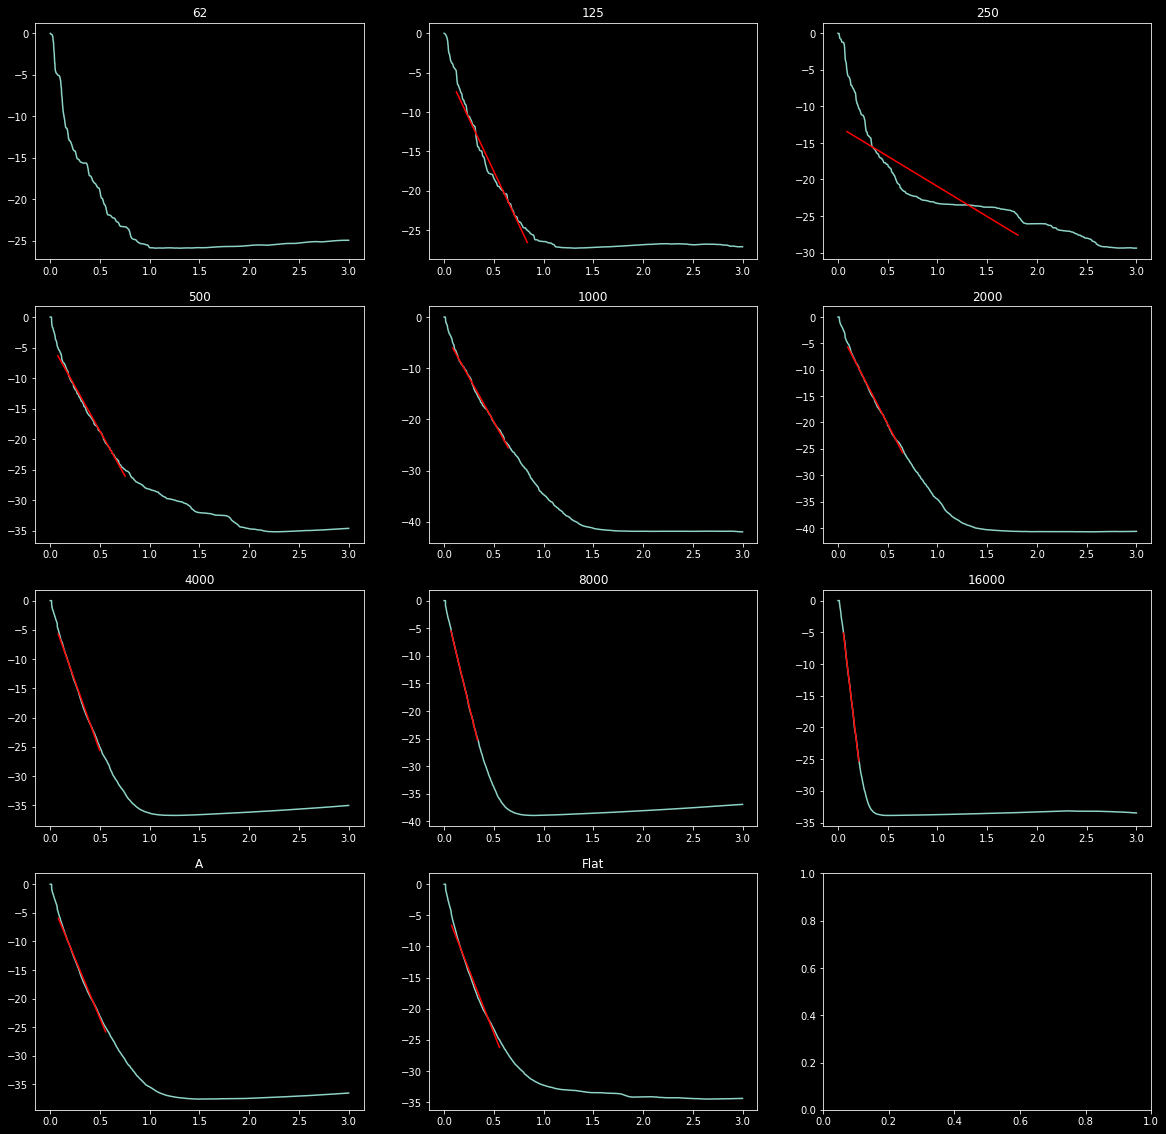

In [29]:
parsdecay_plot(pars,fs=fs)

# Funcion Transferencia

La funcion **spectrum_plot** grafica y devuelve el espectro (power spectral density) y la fft como amplitud y fase de una señal arbitraria (multicanal)

Si pasamos la respuesta impulso como señal recibimos la funcion de transferencia. El primer parametro puede ser un array o un nombre de archivo. Si es array hay que especificar la frecuencia de sampleo. logscale se refiere a la escala de frecuencias (la magnitud esta en dB). fmax es la frecuencia maxima que muestra en el grafico pero calcula todo hasta Nyquist. Devuelve un diccionario con keys 'f' 's' 'amplitude' 'phase' correspondientes a la lista de frecuencias, y arrays 2D (un canal por fila) con el espectro de potencias, la amplitud y la fase de la fft respectivamente.
bajo

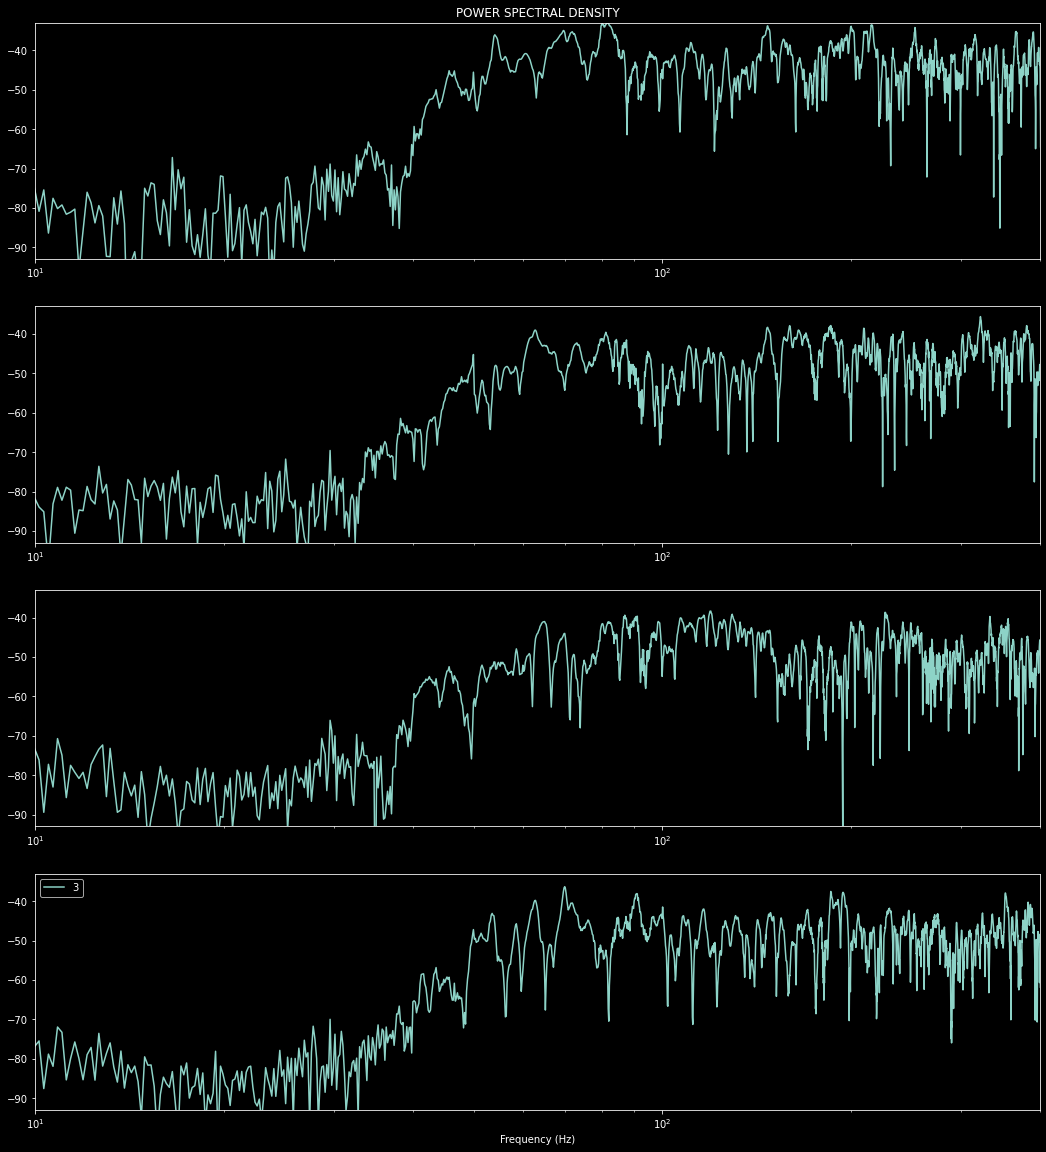

In [31]:
sp = spectrum_plot(ir1, logscale=True, fmax=400, fs=fs)

# Espectrograma

Como en el caso anterior, **spectrogram_plot** grafica y devuelve el espectrograma (ahora de un solo canal que se puede especificar con el parametro chan). 
recibe como parametros ademas de la señal en primero lugar, el tamaño de ña ventana en samples 'window', el overlap de las ventanas en samples 'overlap' la frecuencia de sampleo y el rango en dB 'lrange'. 'normalize' = True normaliza la salida en amplitud.
Atencion, por ahora necesita el array (no el nombre de archivo)

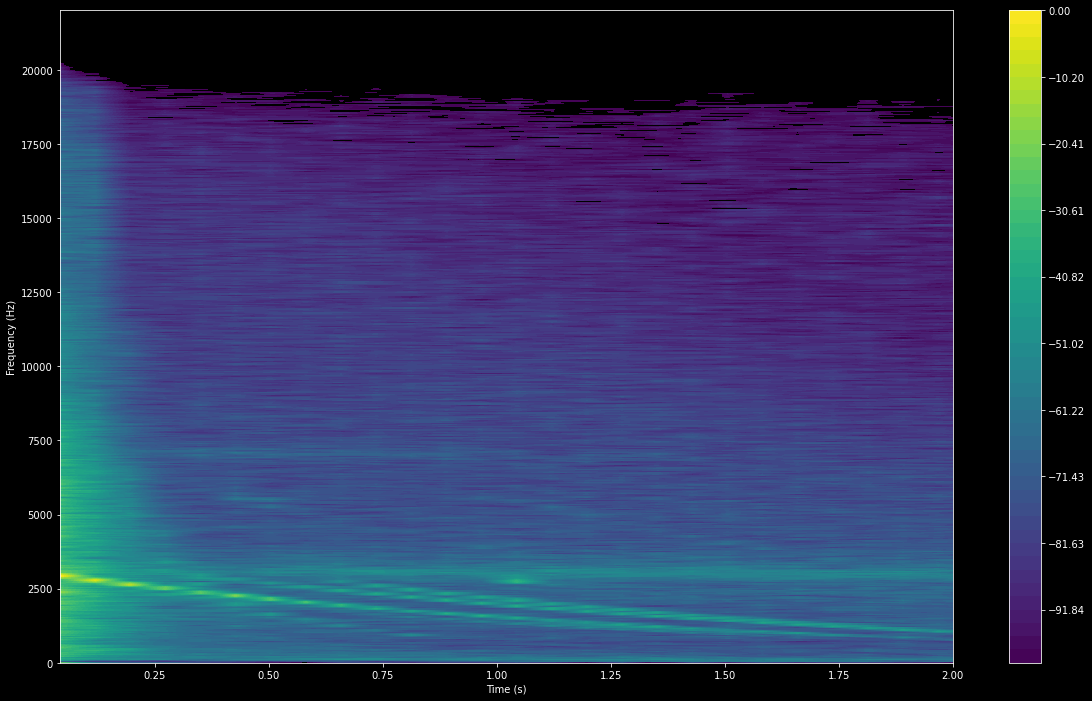

In [26]:
spec = spectrogram_plot(ir1,4096,400,chan=0,normalized=True,fs=fs,lrange=100,fmax=22000)

# ANEXO. 

Reproducir y grabar un archivo de audio, en otra sesion para diferenciar

In [5]:
tipo = "rec"
inchan = [0,1,2,3,4]
outchan = [0]
parlantes = ["L","R","centro","orq","paso1","paso2","paso3","paso4"]
mics = ["pub1","pub2","pub3","pub4"]
s2 = RecordingSession("CETC2",parlantes,mics,inchan=inchan,outchan=outchan,rtype=tipo,sweepfile="sweep_x1_48k_10s_30_22k")

In [15]:
#filename = "audios/Pasaje compuesto de estímulos varios"
filename = "audios/Pasaje compuesto de estímulos varios"
parlante = 8
direction = 5
mic = 2
take = 2
s2.playrec_file(filename,parlante,mic,take=take,channel=0,comment=' prueba')

Recording Audio file audios/Pasaje compuesto de estímulos varios in audios/Pasaje compuesto de estímulos varios_CETC2_Spaso4_Mpub2_D1_5ch_rec_(2)
finished
Maximum sample value = 1.3032840490341187


In [17]:
s2.save_metadata("Session2_full")

In [18]:
s2.list_recordings()

0:audios/caidas_CETC2_SL_Mpub2_D1_5ch_rec
1:audios/Sonidos graves motores_CETC2_SL_Mpub2_D1_5ch_rec
2:audios/Sonidos graves motores_CETC2_SL_Mpub2_D1_5ch_rec
3:audios/crujidos_CETC2_SL_Mpub2_D1_5ch_rec
4:audios/caidas_CETC2_SL_Mpub2_D1_5ch_rec
5:audios/Pasaje con doppler y campo electromagnético_CETC2_SL_Mpub2_D1_5ch_rec
6:audios/Pasaje compuesto de estímulos varios_CETC2_SL_Mpub2_D1_5ch_rec
7:audios/Pasaje compuesto de estímulos varios_CETC2_Spaso3_Mpub2_D1_5ch_rec
8:audios/Pasaje compuesto de estímulos varios_CETC2_Spaso4_Mpub2_D1_5ch_rec_(2)
